This Jupyter Notebook was presented during Software Demo Days. A link to that presentation can be found here: https://www.youtube.com/watch?v=FqW7Xpl_VNk

# Starting Out

Some reminder notes about MoorDyn:
- MoorDyn is a library driven by an external code
  - Common publicly available drivers are WEC-Sim and OpenFAST, there are also numerous private drivers that have been built
  - You can also build your own driver, which is what we do here in this demo
- The driver can either represent a larger system, like a floating wave energy converter, or it can drive the MoorDyn code in simulating a stand-alone system

For this demo, we will be running MoorDyn-C using the example cases from the [MoorDyn documentation](https://moordyn.readthedocs.io/en/latest/drivers.html#python) and the [MoorDyn-C test library](https://github.com/FloatingArrayDesign/MoorDyn/tree/master/tests/Mooring). We will drive these systems by moving the fairleads at a constant velocity.

To run MoorDyn-F, you need to use the MoorDyn-F driver. While it's beyond what we will talk about today, instructions and example files can be found in the `MoorDynF_example/` directory.


In [ ]:
# start by importing necessary modules

import moordyn
import moorpy # a nice tool for visualizing moordyn
import numpy as np

# 3-lines Simple Example

## Input File

For the first example, we will be simulating three catenary chain moorings on a floating wind turbine platform with no water kinematics \(waves and currents\). This is the mooring system of the OC3 Hywind Spar from [Jonkman 2010](https://www.nrel.gov/docs/fy10osti/47535.pdf) shown below.

<img src="jonkman_2010_3-1.png" alt="OC3 Spar Mooring" width="400">

These three mooring lines are attached to the platform at 70 m below the waterline and 5.2 m from the platform center, this location is known as the fairlead (represented as a MoorDyn point object). 
We will run this simulation by telling MoorDyn how each fairlead is moving, and MoorDyn will output to our driver the forces at each fairlead. MoorDyn will also
produce output files that describe how the system is performing.

This setup looks like the following MoorDyn input file:

```
--------------------- MoorDyn Input File ------------------------------------
MoorDyn input file of the mooring system for OC3-Hywind
----------------------- LINE TYPES ------------------------------------------
TypeName   Diam    Mass/m     EA         BA/-zeta    EI         Cd     Ca     CdAx    CaAx
(name)     (m)     (kg/m)     (N)        (N-s/-)     (N-m^2)    (-)    (-)    (-)     (-)
main       0.09    77.7066    384.243E6  -0.8        0          1.6    1.0    0.1     0.0
---------------------- POINT PROPERTIES --------------------------------
ID    Type      X       Y       Z       Mass   Volume  CdA    Ca
(#)   (-)       (m)     (m)     (m)     (kg)   (mˆ3)   (m^2)  (-)
1     Fixed     853.87  0       -320.0  0      0       0      0
2     Fixed     -426.94 739.47  -320.0  0      0       0      0
3     Fixed     -426.94 -739.47 -320.0  0      0       0      0
4     Coupled    5.2     0.0     -70.0   0      0       0      0
5     Coupled    -2.6    4.5     -70.0   0      0       0      0
6     Coupled    -2.6    -4.5    -70.0   0      0       0      0
---------------------- LINES ----------------------------------------
ID   LineType   AttachA  AttachB  UnstrLen  NumSegs  LineOutputs
(#)   (name)     (#)      (#)       (m)       (-)     (-)
1     main       1        4         902.2     20      p
2     main       2        5         902.2     20      p
3     main       3        6         902.2     20      p
---------------------- OPTIONS -----------------------------------------
2             writeLog      Write a log file
0.002         dtM           time step to use in mooring integration (s)
3.0e6         kBot          bottom stiffness (Pa/m)
3.0e5         cBot          bottom damping (Pa-s/m)
1025.0        WtrDnsty      water density (kg/m^3)
320           WtrDpth       water depth (m)
1.0           dtIC          time interval for analyzing convergence during IC gen (s)
100.0         TmaxIC        max time for ic gen (s)
4.0           CdScaleIC     factor by which to scale drag coefficients during dynamic relaxation (-)
0.001         threshIC      threshold for IC convergence (-)
1             disableOutTime
---------------------- OUTPUTS -----------------------------------------
FairTen1
FairTen2
FairTen3
------------------------- need this line -------------------------------------- 
```

More information on MoorDyn input files can be found in the [V2 input file section of the documentation](https://moordyn.readthedocs.io/en/latest/inputs.html#the-v2-input-file).



## Initialization
First, we initialize the system:

In [ ]:
# Create the MoorDyn system from the input file
system = moordyn.Create("lines.txt")

# Set the initial positions in this driver code to what was defined in the input file
x = np.array([ 5.2,  0.0, -70.0,   # point 4
              -2.6,  4.5, -70.0,   # point 5
              -2.6, -4.5, -70.0])  # point 6

# Set the velocities to zero. 3 coupled points x 3 DoF per point = 9 DoF
xd = np.zeros(9)
# Formerly:
    # xd = [0] * 9

# Setup the initial condition
moordyn.Init(system, x, xd)


 Running MoorDyn (v2.4.0)
         MoorDyn v2 has significant ongoing input file changes from v1.
   Copyright: (C) 2024 National Renewable Energy Laboratory, (C) 2014-2019 Matt Hall
   This program is released under the  BSD 3-Clause license.
The filename is lines.txt
MoorDyn v2 log file with output level MSG at 'lines.log'
Generated entities:
	nLineTypes  = 1
	nRodTypes   = 0
	nPoints     = 6
	nBodies     = 0
	nRods       = 0
	nLines      = 3
	nFails      = 0
	nFreeBodies = 0
	nFreeRods   = 0
	nFreePoints  = 0
	nCpldBodies = 0
	nCpldRods   = 0
	nCpldPoints = 3
Time integrator = 2nd order Runge-Kutta
Water kinematics for IC gen:
   No Waves or Currents, or set externally
Creating mooring system...
Initializing coupled Point 4 at 5.2, 0, -70
Initializing coupled Point 5 at -2.6, 4.5, -70
Initializing coupled Point 6 at -2.6, -4.5, -70
dtM = 0.002 s (CFL = 0.015691)
Finalizing ICs using static solve
  - Line1:
    ID      : 1
    UnstrLen: 902.2
    N       : 20
    d       : 0.09
    

0

## Time Stepping

Then we run the simulation, moving the fairleads at 0.5 m/s in the x direction:

In [ ]:
# Make the points move at 0.5 m/s to the positive x direction
for i in range(3):
    xd[3 * i] = 0.5
t, dt = 0.0, 0.5

# Run the simulation for five timesteps
for i in range(5):
    f = moordyn.Step(system, x, xd, t, dt)
    t += dt # update the time
    x += xd * dt # update the position 

# Print the last output fairlead tensions on the lines (the vector sum of the forces returned by moordyn)
print("Tensions at the fairleads:")
print("FairTen1 = ", np.linalg.norm(f[0:3]))
print("FairTen2 = ", np.linalg.norm(f[3:6]))
print("FairTen3 = ", np.linalg.norm(f[6:9]))
    
# Alright, time to finish!
moordyn.Close(system)

Tensions at the fairleads:
FairTen1 =  827414.2252929022
FairTen2 =  939998.8305276999
FairTen3 =  939998.8305276999


0

## Visualizing

MoorPy, a quasi-static mooring solver, can be used to visualize the outputs of MoorDyn. The details of MoorPy are beyond the scope of this example but can be found on the [MoorPy docs page](https://moorpy.readthedocs.io/en/latest/). In order to make the MoorDyn system compatible with MoorPy visualization, we need to output the line node positions. This is why we included the **p** flag in the LineOutputs:
```
---------------------- LINES ----------------------------------------
ID   LineType   AttachA  AttachB  UnstrLen  NumSegs  LineOutputs
(#)   (name)     (#)      (#)       (m)       (-)     (-)
1     main       1        4         902.2     20       p
```


attempting to read lines.txt
Mooring input file 'lines.txt' loaded successfully.
attempting to load ./lines_Line1.out
attempting to load ./lines_Line2.out
attempting to load ./lines_Line3.out


(<Figure size 600x400 with 1 Axes>, <Axes3D: >)

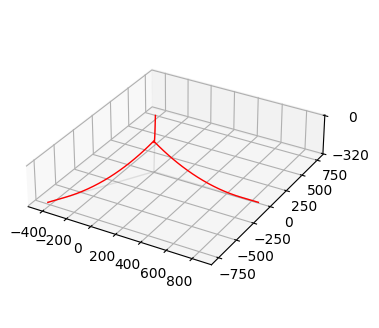

In [5]:
# Create a MoorPy system (this loads the moordyn outputs found in <dirname>/<rootname>_<object>#.out, where <object> is either Line or Rod and # is the corresponding number)
ms = moorpy.System(file="lines.txt", dirname="./", rootname="lines", qs = 0, Fortran = False) # qs tells MoorPy it is loading a MoorDyn system, Fortran = False tells it to use the MoorDyn-C output format

# Plot the results at t = 0 in red
ms.plot(color="red", time = 0)

# 3-lines with Body Simple Example

## Input File

For the second example, we will be running a very similar setup to the previous case, but this time we will couple to a rigid body.
Similar to how the previous case is set up, we have three catenary lines. However, this time, the fairleads are attached to a rigid body,
which is then coupled to the external code. When using a rigid body, we need to be strategic about how we define positions because the body 
motion controls the fairlead motion. For our setup, we define the body at `0, 0, -70`, which is the depth of the fairlead attachments in 
the previous example. The fairlead locations are then defined in that body's reference frame.


This setup looks like the following MoorDyn input file:

```
--------------------- MoorDyn Input File ------------------------------------
MoorDyn input file of the mooring system for OC3-Hywind
----------------------- LINE TYPES ------------------------------------------
TypeName   Diam    Mass/m     EA         BA/-zeta    EI         Cd     Ca     CdAx    CaAx
(name)     (m)     (kg/m)     (N)        (N-s/-)     (N-m^2)    (-)    (-)    (-)     (-)
main       0.09    77.7066    384.243E6  -0.8        0          1.6    1.0    0.1     0.0
----------------------- BODIES ------------------------------------------------------
ID   Attachment  X0   Y0   Z0   r0    p0    y0   Mass  CG*   I*     Volume  CdA*   Ca*
(#)     (-)      (m)  (m)  (m) (deg) (deg) (deg) (kg)  (m) (kg-m^2) (m^3)   (m^2)  (-)
1    Coupled      0    0  -70    0     0     0     0    0     0       0       0     0
---------------------- POINT PROPERTIES --------------------------------
ID    Type      X       Y       Z       Mass   Volume  CdA    Ca
(#)   (-)       (m)     (m)     (m)     (kg)   (mˆ3)   (m^2)  (-)
1     Fixed     853.87  0       -320.0  0      0       0      0
2     Fixed     -426.94 739.47  -320.0  0      0       0      0
3     Fixed     -426.94 -739.47 -320.0  0      0       0      0
4     Body1    5.2     0.0        0.0   0      0       0      0
5     Body1    -2.6    4.5        0.0   0      0       0      0
6     Body1    -2.6    -4.5       0.0   0      0       0      0
---------------------- LINES ----------------------------------------
ID   LineType   AttachA  AttachB  UnstrLen  NumSegs  LineOutputs
(#)   (name)     (#)      (#)       (m)       (-)     (-)
1     main       1        4         902.2     20      p
2     main       2        5         902.2     20      p
3     main       3        6         902.2     20      p
---------------------- OPTIONS -----------------------------------------
2             writeLog      Write a log file
0.002         dtM           time step to use in mooring integration (s)
3.0e6         kBot          bottom stiffness (Pa/m)
3.0e5         cBot          bottom damping (Pa-s/m)
1025.0        WtrDnsty      water density (kg/m^3)
320           WtrDpth       water depth (m)
1.0           dtIC          time interval for analyzing convergence during IC gen (s)
100.0         TmaxIC        max time for ic gen (s)
4.0           CdScaleIC     factor by which to scale drag coefficients during dynamic relaxation (-)
0.001         threshIC      threshold for IC convergence (-)
1             disableOutTime
---------------------- OUTPUTS -----------------------------------------
FairTen1
FairTen2
FairTen3
------------------------- need this line -------------------------------------- 
```

## Initialization

First, we initialize the system. In this case, we will lean more heavily on the MoorDyn-C API:

In [ ]:
# Create the MoorDyn system from the input file
system = moordyn.Create("body.txt")

# You can get the initial positions and velocities from the system itself using the MoorDyn-C API
body = moordyn.GetBody(system, 1)
state = moordyn.GetBodyState(body) # tuple with (x, xd)

x = np.array(state[0]) # x, y, z, roll, pitch, yaw 
xd = np.array(state[1]) # xdot, ydot, zdot, roll_dot, pitch_dot, yaw_dot 

# Setup the initial condition
moordyn.Init(system, x, xd)


 Running MoorDyn (v2.4.0)
         MoorDyn v2 has significant ongoing input file changes from v1.
   Copyright: (C) 2024 National Renewable Energy Laboratory, (C) 2014-2019 Matt Hall
   This program is released under the  BSD 3-Clause license.
The filename is body.txt
MoorDyn v2 log file with output level MSG at 'body.log'
Generated entities:
	nLineTypes  = 1
	nRodTypes   = 0
	nPoints     = 6
	nBodies     = 1
	nRods       = 0
	nLines      = 3
	nFails      = 0
	nFreeBodies = 0
	nFreeRods   = 0
	nFreePoints  = 0
	nCpldBodies = 1
	nCpldRods   = 0
	nCpldPoints = 0
Time integrator = 2nd order Runge-Kutta
Water kinematics for IC gen:
   No Waves or Currents, or set externally


0

Creating mooring system...
Initializing coupled Body 1 at 0, 0, -70...
dtM = 0.002 s (CFL = 0.015691)
Finalizing ICs using static solve
  - Line1:
    ID      : 1
    UnstrLen: 902.2
    N       : 20
    d       : 0.09
    rho     : 12214.7
    EAMod   : 1
    EA      : 3.84243e+08
    BA      : -0.8
    EI      : 0
    Can     : 1
    Cat     : 0
    Cdn     : 1.6
    Cdt     : 0.1
    Cl      : 0
    dF      : 0
    cF      : 0
    ww_l    : 698.333
Line 1 damping set to 9.80212e+08 Pa-s = 6.23584e+06 Ns, based on input of -0.8
Initialized Line 1
  - Line2:
    ID      : 2
    UnstrLen: 902.2
    N       : 20
    d       : 0.09
    rho     : 12214.7
    EAMod   : 1
    EA      : 3.84243e+08
    BA      : -0.8
    EI      : 0
    Can     : 1
    Cat     : 0
    Cdn     : 1.6
    Cdt     : 0.1
    Cl      : 0
    dF      : 0
    cF      : 0
    ww_l    : 698.333
Line 2 damping set to 9.80212e+08 Pa-s = 6.23584e+06 Ns, based on input of -0.8
Initialized Line 2
  - Line3:
    ID      : 3

## Time Stepping

Then we run the simulation, moving the fairleads by moving the body at 0.5 m/s in the x direction:

In [ ]:
# Make the body move at 0.5 m/s to the positive x direction
xd[0] = 0.5 # 0 index is the first of 6 DOF
t, dt = 0.0, 0.5

# Run the simulation for five timesteps
for i in range(5):
    f = moordyn.Step(system, x, xd, t, dt)
    t += dt
    x += xd * dt # update the position 

# Print the last output fairlead tensions on the lines (the vector sum of the forces returned by moordyn)
point4 = moordyn.GetPoint(system, 4)
point5 = moordyn.GetPoint(system, 5)
point6 = moordyn.GetPoint(system, 6)
print("FairTen1 = ", np.linalg.norm(moordyn.GetPointForce(point4)))
print("FairTen2 = ", np.linalg.norm(moordyn.GetPointForce(point5)))
print("FairTen3 = ", np.linalg.norm(moordyn.GetPointForce(point6)))

# Alright, time to finish!
moordyn.Close(system)

FairTen1 =  827414.2252929765
FairTen2 =  939998.8305276999
FairTen3 =  939998.8305276999


0

## Visualization

Now let's visualize with MoorPy!

attempting to read body.txt
Mooring input file 'body.txt' loaded successfully.
attempting to load ./body_Line1.out
attempting to load ./body_Line2.out
attempting to load ./body_Line3.out


(<Figure size 600x400 with 1 Axes>, <Axes3D: >)

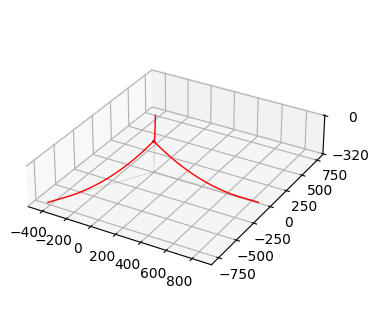

In [ ]:
# Create a MoorPy system (this loads the moordyn outputs found in <dirname>/<rootname>_<object>#.out, where <object> is either Line or Rod and # is the corresponding number). File is required for MoorPy to know the mooring system parameters. 
ms = moorpy.System(file="body.txt", dirname="./", rootname="body", qs = 0, Fortran = False) # qs tells MoorPy it is loading a MoorDyn system, Fortran = False tells it to use the MoorDyn-C output format

# Plot the results at t = 0 in red
ms.plot(color="red", time = 0)

# Closing Notes

The process for running MoorDyn as described here is the same internals that OpenFAST and WEC-Sim both use when running coupled with MoorDyn. 
At each timestep, the forces returned by MoorDyn are passed into these codes and used to determine the new position of the device which is 
passed back to MoorDyn. In those codes, all you need to do is provide the MoorDyn input files and enable the relevant flags. The coupling is 
all handled internally. 

MoorDyn is always looking for new projects to engage with. Couplings are underway with Chrono and Hydrochrono as well as numerous commercial codes. Any 
new collaboration would be more than welcome!